In [14]:
import numpy as np
import matplotlib.pyplot as plt

### Definición de constantes y parámetros del problema

In [15]:
c = 299792458.0

f0 = 1e9
er1 = 1
er2 = 16.0
ert = 4.0

eps0 = 8.854e-12
eps1 = 8.854e-12
eps2 = er1 * eps0
epst = np.sqrt(eps1 * eps2)

eta0 = 120 * np.pi
eta1 = eta0 / np.sqrt(er1)  
eta2 = eta0 / np.sqrt(er2)  
etat = eta0 / np.sqrt(ert)

# Lambda en la lámina a f0
lambda_m0 = c / (f0 * np.sqrt(epst / eps0))

# Espesor de la lámina (cuarto de onda)
d = lambda_m0 / 4


# Parte a

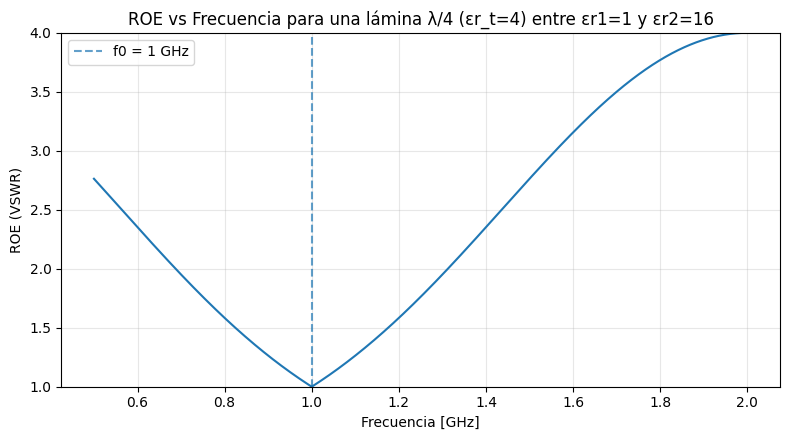

In [16]:
f = np.linspace(f0/2, 2*f0, 2001) 

beta_d = (np.pi/2.0) * (f / f0)
tan_bd = np.tan(beta_d)

Zin = etat * (eta2 + 1j * etat * tan_bd) / (etat + 1j * eta2 * tan_bd)

Gamma = (Zin - eta1) / (Zin + eta1)

ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))

# Graficar ROE vs frecuencia
plt.figure(figsize=(8, 4.5))
plt.plot(f/1e9, ROE)
plt.axvline(f0/1e9, linestyle='--', alpha=0.7, label='f0 = 1 GHz')
plt.ylim(1, min(5, np.nanmax(ROE)))   
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('ROE (VSWR)')
plt.title('ROE vs Frecuencia para una lámina λ/4 (εr_t=4) entre εr1=1 y εr2=16')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Parte b

f1 = 0.825 GHz
f2 = 1.175 GHz
BW = 350.2 MHz  (35.02% de f0)


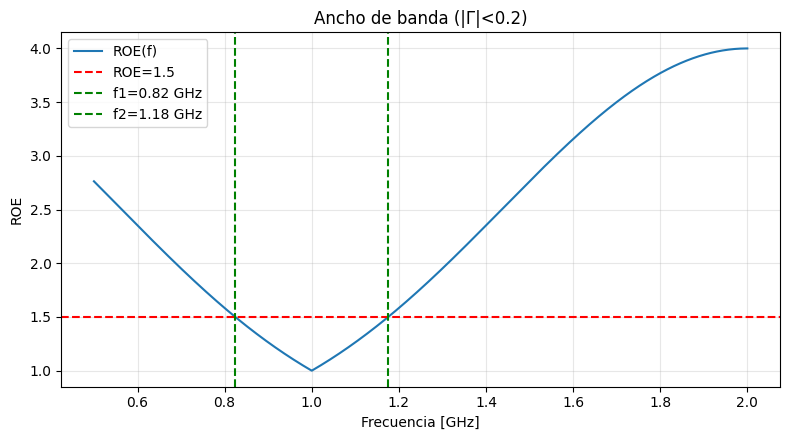

In [17]:
umbral_ROE = 1.5  # |Γ|<0.2  <=>  ROE<1.5
mask = ROE < umbral_ROE
idx = np.where(mask)[0]
splits = np.where(np.diff(idx) > 1)[0] + 1
tramos = np.split(idx, splits)
f0 = 1e9
tramo_ok = min(tramos, key=lambda t: abs(f[t].mean()-f0))
f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]
BW, BW_pct = f2 - f1, (f2 - f1)/f0*100

print(f"f1 = {f1/1e9:.3f} GHz")
print(f"f2 = {f2/1e9:.3f} GHz")
print(f"BW = {BW/1e6:.1f} MHz  ({BW_pct:.2f}% de f0)")

plt.figure(figsize=(8,4.5))
plt.plot(f/1e9, ROE, label='ROE(f)')
plt.axhline(umbral_ROE, color='r', ls='--', label='ROE=1.5')
plt.axvline(f1/1e9, color='g', ls='--', label=f'f1={f1/1e9:.2f} GHz')
plt.axvline(f2/1e9, color='g', ls='--', label=f'f2={f2/1e9:.2f} GHz')
plt.xlabel('Frecuencia [GHz]'); plt.ylabel('ROE'); plt.title('Ancho de banda (|Γ|<0.2)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()



# Parte C

εr2 = 2.5198, εr3 = 6.3496
d2 = 47.21 mm, d3 = 29.74 mm

Ancho de banda |Γ| < 0.2:
  f1 = 1.000 GHz
  f2 = 1.000 GHz
  BW = 0.0 MHz  (0.0% de f0)



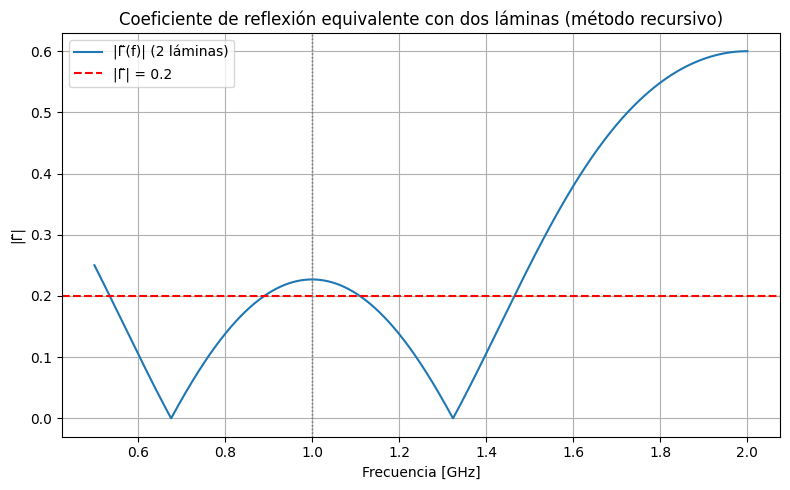

In [18]:
# --- Medios extremos ---
eta1 = eta0            # εr1 = 1
eta4 = eta0 / 4.0      # εr4 = 16

# --- Impedancias intermedias ---
eta2 = eta1 * (eta4 / eta1) ** (1 / 3)
eta3 = eta1 * (eta4 / eta1) ** (2 / 3)

# --- Permitividades relativas y espesores (λ/4 en f0) ---
er2 = (eta0 / eta2) ** 2
er3 = (eta0 / eta3) ** 2

lambda0 = c / f0
d2 = lambda0 / (4 * np.sqrt(er2))
d3 = lambda0 / (4 * np.sqrt(er3))

print(f"εr2 = {er2:.4f}, εr3 = {er3:.4f}")
print(f"d2 = {d2*1e3:.2f} mm, d3 = {d3*1e3:.2f} mm\n")

# --- Rango de frecuencias ---
f = np.linspace(f0/2, 2*f0, 4001)
beta2 = 2*np.pi*f*np.sqrt(er2)/c
beta3 = 2*np.pi*f*np.sqrt(er3)/c

# --- Coeficientes de reflexión locales ---
Gamma12 = (eta2 - eta1) / (eta2 + eta1)
Gamma23 = (eta3 - eta2) / (eta3 + eta2)
Gamma34 = (eta4 - eta3) / (eta4 + eta3)

# --- Reflexión total (método recursivo) ---
Gamma_tot = np.zeros_like(f, dtype=complex)

for i in range(len(f)):
    # Desde la última interfaz hacia atrás
    exp3 = np.exp(-2j * beta3[i] * d3)
    Gamma3ef = (Gamma34 + 0 * exp3) / (1 + Gamma34 * 0 * exp3)  # Carga es medio 4
    Gamma2ef = (Gamma23 + Gamma3ef * exp3) / (1 + Gamma23 * Gamma3ef * exp3)

    exp2 = np.exp(-2j * beta2[i] * d2)
    Gamma1ef = (Gamma12 + Gamma2ef * exp2) / (1 + Gamma12 * Gamma2ef * exp2)

    Gamma_tot[i] = Gamma1ef

Gamma_abs = np.abs(Gamma_tot)

# --- Cálculo de ancho de banda ---
th = 0.2
mask = Gamma_abs < th
idx0 = np.argmin(np.abs(f - f0))
i1, i2 = idx0, idx0
while i1 > 0 and mask[i1-1]:
    i1 -= 1
while i2 < len(f)-1 and mask[i2+1]:
    i2 += 1
f1, f2 = f[i1], f[i2]
BW = f2 - f1

print(f"Ancho de banda |Γ| < 0.2:")
print(f"  f1 = {f1/1e9:.3f} GHz")
print(f"  f2 = {f2/1e9:.3f} GHz")
print(f"  BW = {BW/1e6:.1f} MHz  ({BW/f0*100:.1f}% de f0)\n")

# --- Gráfica final ---
plt.figure(figsize=(8,5))
plt.plot(f/1e9, Gamma_abs, label='|Γ̃(f)| (2 láminas)')
plt.axhline(th, color='r', linestyle='--', label='|Γ̃| = 0.2')
plt.axvline(f1/1e9, color='gray', linestyle=':', linewidth=1)
plt.axvline(f2/1e9, color='gray', linestyle=':', linewidth=1)
plt.title('Coeficiente de reflexión equivalente con dos láminas (método recursivo)')
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('|Γ̃|')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Parte d:
Graficar el ancho de banda en función del número n de láminas a insertar entre los dos medios.

n = 1:  f1 = 0.500 GHz,  f2 = 1.679 GHz,  BW = 1179.0 MHz  (117.90% de f0)
n = 2:  f1 = 0.500 GHz,  f2 = 1.802 GHz,  BW = 1302.0 MHz  (130.20% de f0)
n = 3:  f1 = 0.500 GHz,  f2 = 1.855 GHz,  BW = 1355.2 MHz  (135.53% de f0)
n = 4:  f1 = 0.500 GHz,  f2 = 1.885 GHz,  BW = 1385.2 MHz  (138.53% de f0)
n = 5:  f1 = 0.500 GHz,  f2 = 1.905 GHz,  BW = 1405.1 MHz  (140.51% de f0)
n = 6:  f1 = 0.500 GHz,  f2 = 1.919 GHz,  BW = 1418.6 MHz  (141.86% de f0)
n = 7:  f1 = 0.500 GHz,  f2 = 1.929 GHz,  BW = 1429.1 MHz  (142.91% de f0)
n = 8:  f1 = 0.500 GHz,  f2 = 1.937 GHz,  BW = 1437.0 MHz  (143.70% de f0)
n = 9:  f1 = 0.500 GHz,  f2 = 1.943 GHz,  BW = 1443.4 MHz  (144.34% de f0)
n = 10:  f1 = 0.500 GHz,  f2 = 1.949 GHz,  BW = 1448.6 MHz  (144.86% de f0)
n = 11:  f1 = 0.500 GHz,  f2 = 1.953 GHz,  BW = 1452.8 MHz  (145.28% de f0)
n = 12:  f1 = 0.500 GHz,  f2 = 1.956 GHz,  BW = 1456.5 MHz  (145.65% de f0)
n = 13:  f1 = 0.500 GHz,  f2 = 1.960 GHz,  BW = 1459.5 MHz  (145.95% de f0)
n = 14:  f1 = 0.500 G

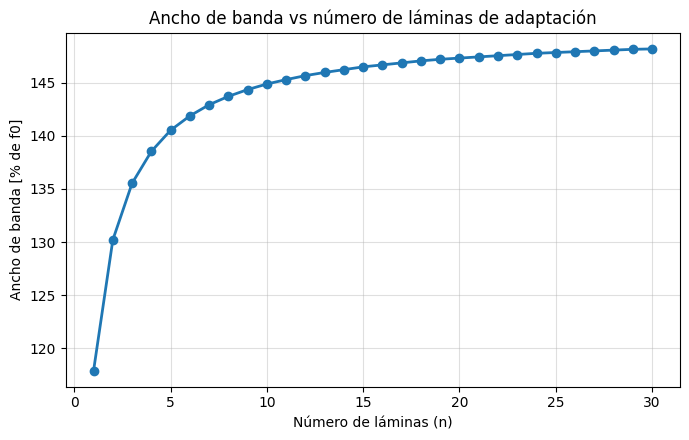

In [20]:
umbral_gamma = 0.2

def multilamina_ROE(n, f, f0, eta1, eta2):
    """
    Calcula ROE(f) y |Gamma|(f) para n láminas de adaptación entre dos medios.
    Cada lámina tiene espesor λ/4 a f0 y impedancia intermedia (progresión geométrica).
    """
    
    eta_layers = []  

    for i in range(1, n + 1):
        fraccion = i / (n + 1)
        eta_i = eta1 * (eta2 / eta1) ** fraccion
        eta_layers.append(eta_i)

    eta_total = [eta1] + eta_layers + [eta2]

    Gamma = np.zeros_like(f, dtype=complex)

    for i, freq in enumerate(f):
        Zin = eta_total[-1]
        for et in reversed(eta_total[:-1]):
            beta_d = (np.pi/2) * (freq / f0)  
            Zin = et * (Zin + 1j*et*np.tan(beta_d)) / (et + 1j*Zin*np.tan(beta_d))
        Gamma[i] = (Zin - eta1) / (Zin + eta1)

    ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))
    return ROE, Gamma


n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
BW_pct_list = []

for n in n_values:
    ROE, Gamma = multilamina_ROE(n, f, f0, eta1, eta2)

    mask = np.abs(Gamma) < umbral_gamma
    idx = np.where(mask)[0]

    splits = np.where(np.diff(idx) > 1)[0] + 1
    tramos = np.split(idx, splits)

    tramo_ok = min(tramos, key=lambda t: abs(f[t].mean() - f0))
    f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]

    BW_abs = f2 - f1
    BW_pct = (BW_abs / f0) * 100
    BW_pct_list.append(BW_pct)

    print(f"n = {n}:  f1 = {f1/1e9:.3f} GHz,  f2 = {f2/1e9:.3f} GHz,  "
          f"BW = {BW_abs/1e6:.1f} MHz  ({BW_pct:.2f}% de f0)")

# Gráfica de ancho de banda vs número de láminas
plt.figure(figsize=(7,4.5))
plt.plot(n_values, BW_pct_list, marker='o', linewidth=2)
plt.title('Ancho de banda vs número de láminas de adaptación')
plt.xlabel('Número de láminas (n)')
plt.ylabel('Ancho de banda [% de f0]')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
